In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn_tda as sktda
import statmapper as stm
import networkx as nx
import pandas as pd

from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing 
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import pairwise_distances, log_loss
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from stochmapper import *

# Annulus

## Dataset

### Underlying manifold

In [4]:
num_pts = 5000
radius  = 1.

In [5]:
theta   = np.random.uniform(low=0., high=2*np.pi, size=num_pts)
xs, ys  = radius * np.cos(theta), radius * np.sin(theta)
noise_x = np.random.normal(loc=xs, scale=.1, size=num_pts)
noise_y = np.random.normal(loc=ys, scale=.1, size=num_pts)
X       = np.hstack([np.reshape(xs+noise_x, [-1,1]), np.reshape(ys+noise_y, [-1,1])])

<IPython.core.display.Javascript object>


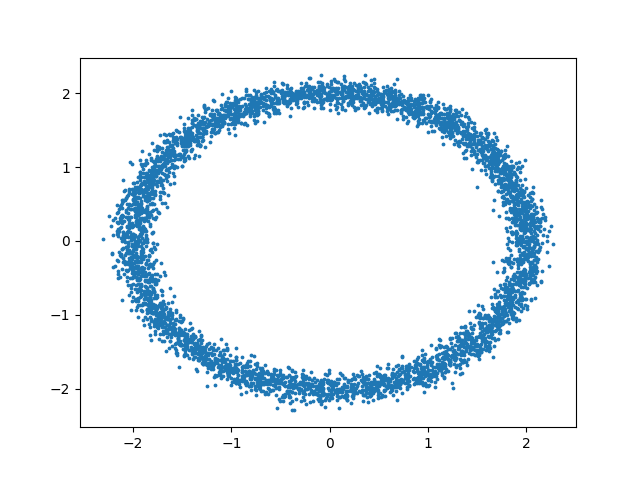

In [6]:
%matplotlib notebook
plt.scatter(X[:,0], X[:,1], s=3)
plt.show()

In [7]:
delta = sktda.estimate_scale(X, 100)
print(delta)

0.1949895319198198


### Probability distributions

#### Known distributions

In [ ]:
distributions = []

In [ ]:
num_samples = 10000

Gaussian distribution.

In [ ]:
for i in range(num_pts):
    distributions.append(np.random.normal(loc=X[i,0], scale=0.5, size=num_samples))

Bimodal distribution.

In [ ]:
for i in range(num_pts):
    distrib = []
    d1 = np.random.normal(loc=X[i,0]+2,  scale=0.1, size=num_samples)
    d2 = np.random.normal(loc=-X[i,0]-2, scale=0.1, size=num_samples)
    distrib = np.concatenate([d1[:int(num_samples/2)], d2[:int(num_samples/2)]])
    np.random.shuffle(distrib)
    distributions.append(distrib)

#### Estimated distributions

In [ ]:
real = []
for i in range(num_pts):
    real.append(np.random.normal(loc=X[i,0], scale=0.5, size=1)[0])

In [8]:
real = []
for i in range(num_pts):
    idx = np.random.choice(2, 1)
    if idx == 0:
        real.append(np.random.normal(loc=X[i,0]+2, scale=0.1, size=1)[0])
    else:
        real.append(np.random.normal(loc=-X[i,0]-2, scale=0.1, size=1)[0])

In [ ]:
distributions = infer_distributions_from_neighborhood(real, X, 3*delta, "point cloud")

#### Graphs

In [ ]:
real = []

In [ ]:
M, m = max(X[:,0]), min(X[:,0])
for i in range(num_pts):
    A = np.random.binomial(1, (X[i,0]-m)/(M-m), size=(5,5))
    Aplus, Aminus = np.triu(A), np.triu(A,1).T
    real.append(nx.Graph(Aplus + Aminus))

### Distances between distributions

In [ ]:
H, C = Histogram(num_bins=100).fit_transform(distributions)

In [ ]:
dists = EuclideanDistance().compute_matrix(H)
print(np.median(dists))

In [ ]:
dists = Wasserstein1D(C=C, p=1).compute_matrix(H)
print(np.median(dists))

In [ ]:
dists = KullbackLeiblerDivergence().compute_matrix(H)
print(np.median(dists))

In [ ]:
dists = np.zeros([num_pts, num_pts])
for i in range(num_pts):
    print(i)
    for j in range(i+1, num_pts):
        GED = nx.optimize_graph_edit_distance(real[i], real[j], upper_bound=20)
        for d in GED:
            dists[i,j] = d
        dists[j,i] = dists[i,j]
print(np.median(dists))

Estimate Lipschitz coefficient.

In [ ]:
D = euclidean_distances(X)
coeff = np.where((D <= delta) & (D > 0), dists/D, np.zeros(D.shape)).max()
print(coeff)

### Visualization

In [ ]:
print([(i,X[i,0]) for i in range(num_pts)])

In [ ]:
plt.figure()
plt.hist(np.array(distributions[60]), bins=300, range=[-4.3,4.3])
plt.show()

Visualize a given realization.

In [ ]:
z = [distributions[i][0] for i in range(num_pts)]

In [ ]:
z = [np.mean(distrib) for distrib in distributions]

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax  = fig.add_subplot(111, projection="3d")
ax.scatter(X[:,0], X[:,1], z, s=1.)
ax.view_init(elev=33, azim=64)
plt.show()

In [ ]:
nx.draw_networkx(real[60], with_labels=False)

## Single realization Mapper

In [ ]:
mapper = sktda.MapperComplex(
    #filters=np.reshape(np.array(real), [-1,1]), 
    filters=np.reshape(np.array([distributions[i][0] for i in range(len(distributions))]), [-1,1]),
    filter_bnds=np.array([[np.nan, np.nan]]),
    resolutions=np.array([15]), gains=np.array([.3]), colors=X[:,0:1],
    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=1.)
                            ).fit(X)

In [ ]:
G = stm.mapper2networkx(mapper)
nx.draw_networkx(G, with_labels=False,
                 node_color=[mapper.node_info_[name]["colors"][0] for name in G.nodes()])

## Mean Stochastic Mapper 

In [ ]:
mapper = MeanStochasticMapperComplex(
    filters=real, infer_distributions=True, threshold=1., hist="NW", kernel=GaussianKernel(h=0.1),
    #filters=distributions, infer_distributions=False,
    resolution=10, gain=.3, colors=X[:,0:1],
    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=delta)
                            ).fit(X)

In [ ]:
G = stm.mapper2networkx(mapper)
nx.draw_networkx(G, with_labels=False,
                 node_color=[mapper.node_info_[name]["colors"][0] for name in G.nodes()])

## General Stochastic Mapper

In [10]:
mapper = StochasticMapperComplex(
    #filters=dists,
    #codomain="distance matrix",
    filters=real,
    codomain="distributions", infer_distributions=True, threshold=1., num_bins=100, 
    hist="NW", kernel=GaussianKernel(h=0.1),
    #filters=distributions,
    #codomain="distributions", infer_distributions=False, num_bins=100,
    cover=VoronoiCover(n_patches=10, threshold=0.01), 
    #distance=EuclideanDistance(), #distance=Wasserstein1D(p=1),
    #cover=EuclideanKMeansCover(n_patches=10, threshold=delta/10),
    #cover=kPDTMCover(n_patches=10, h=3, threshold=delta/2, tol=1e-7),
    #cover=WassersteinKMeansCover(n_patches=10, epsilon=1e-4, p=1, tol=1e-8, threshold=.01),
    correct_Rips=False, delta=delta, n_subdivisions=10,
    colors=np.reshape(X[:,0], [-1,1]), mask=5,
    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=delta)
                            ).fit(X)

<IPython.core.display.Javascript object>


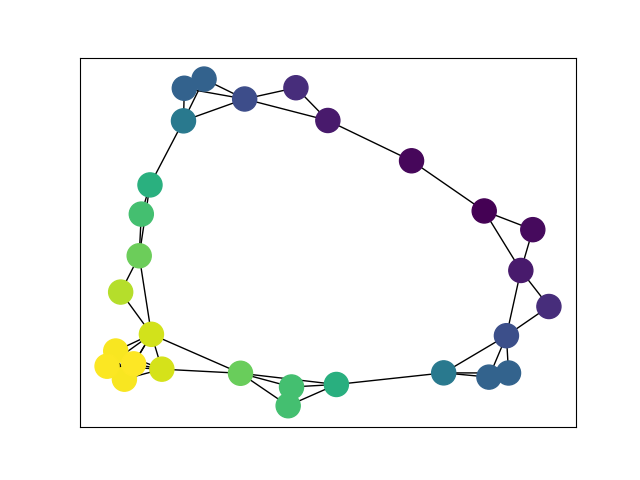

In [11]:
G = stm.mapper2networkx(mapper)
nx.draw_networkx(G, with_labels=False,
                 node_color=[mapper.node_info_[name]["colors"][0] for name in G.nodes()])

# Machine Learning

## Synthetic

In [12]:
np.random.seed(0)

Generate data.

In [13]:
X, y = make_blobs(n_samples=5000, n_features=2, random_state=42, cluster_std=5.0)
X_train, y_train = X[:3000], y[:3000]
X_valid, y_valid = X[3000:4000], y[3000:4000]
X_train_valid, y_train_valid = X[:4000], y[:4000]
X_test, y_test = X[4000:], y[4000:]

<IPython.core.display.Javascript object>


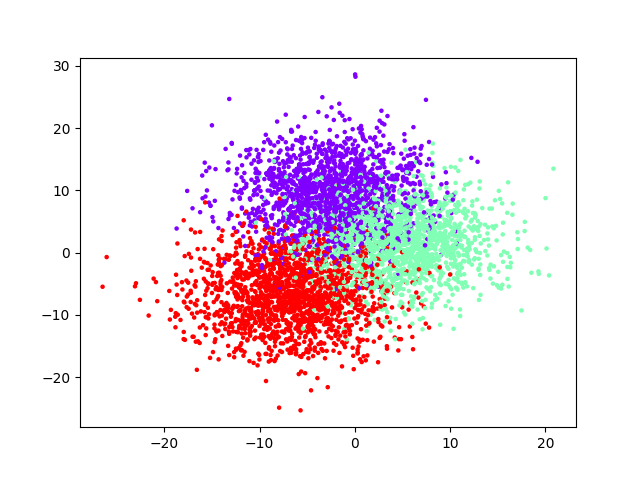

In [14]:
%matplotlib notebook
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=5, cmap="rainbow")
plt.show()

Train uncalibrated random forest classifier on whole train and validation data and evaluate on test data.

In [15]:
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

Train random forest classifier, calibrate on validation data and evaluate on test data.

In [16]:
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)

In [17]:
mapper = sktda.MapperComplex(
    filters=clf_probs,
    filter_bnds=np.array([[np.nan, np.nan]]),
    resolutions=np.array([10,10,10]), gains=np.array([.3,.3,.3]), colors=clf_probs,
    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=10)
                            ).fit(X_test)

<IPython.core.display.Javascript object>


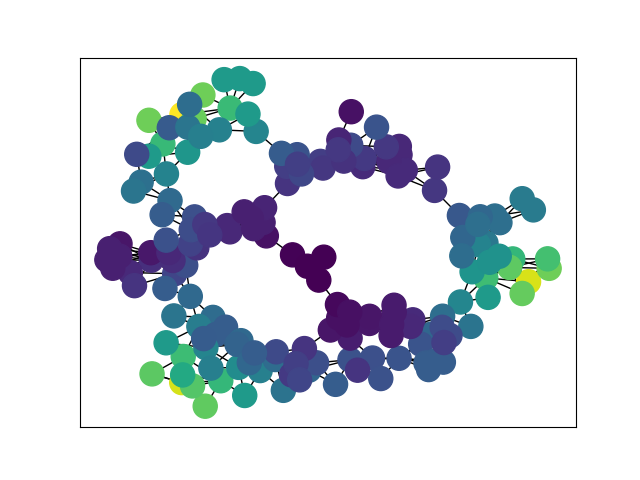

In [18]:
%matplotlib notebook
G = stm.mapper2networkx(mapper)
plt.figure()
nx.draw_networkx(G, with_labels=False, pos=nx.kamada_kawai_layout(G), 
                 node_color=[np.var(mapper.node_info_[name]["colors"]) for name in G.nodes()])

## Accelero

In [19]:
file_path= "/home/mathieu/Documents/data/uci/"

Features.

In [20]:
data_path = file_path + "train/X_train.txt"
activity_features = pd.read_csv(data_path, delim_whitespace=True, header=None)

Activities.

In [21]:
data_path = file_path + "train/y_train.txt"
activity  = pd.read_csv(data_path, delim_whitespace=True, header=None)
activity  = activity.values[:,0] - 1
activity_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']

Subjects.

In [22]:
data_path = file_path + "train/subject_train.txt"
sujet = pd.read_csv(data_path, delim_whitespace=True, header=None)
sujet = sujet.values[:,0]

In [23]:
features_nor = preprocessing.scale(activity_features)

Use naive Bayes for prediction.

In [25]:
gnb = GaussianNB()
gnb.fit(features_nor, activity)
pred = gnb.predict(features_nor)
scores = model_selection.cross_val_score(GaussianNB(), features_nor, activity, cv=10)
print(scores)

[0.70189702 0.66531165 0.67479675 0.55359566 0.83016304 0.64945652
 0.68894952 0.74590164 0.78005464 0.68579235]


Estimation of a posteriori probabilities.

In [26]:
posterior = gnb.predict_proba(features_nor)

In [27]:
delta = sktda.estimate_scale(features_nor, 100)

In [28]:
mapper = sktda.MapperComplex(
    filters=posterior,
    filter_bnds=np.array([[np.nan, np.nan]]),
    resolutions=3*np.ones([6]), gains=.4*np.ones([6]), colors=posterior,
    clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=delta)
                            ).fit(features_nor)

<IPython.core.display.Javascript object>


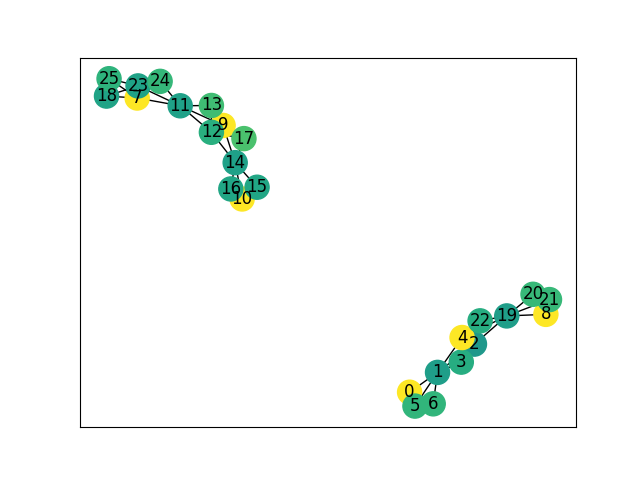

In [29]:
%matplotlib notebook
G = stm.mapper2networkx(mapper)
plt.figure()
nx.draw_networkx(G, with_labels=True,
                 node_color=[np.var(mapper.node_info_[name]["colors"]) for name in G.nodes()],
                 vmin=0., vmax=0.1,
                 labels={name: int(name) for name in G.nodes()})